In [ ]:
import numpy as np
import torch
import torch.nn as nn
from Network.aggregator import BaseAggregator
from Network.model_utils import PPEG, NystromTransformerLayer
from openslide.deepzoom import DeepZoomGenerator
import openslide
import os
import cv2
from PIL import ImageEnhance
class TransMIL(BaseAggregator):
    def __init__(self, num_classes, input_dim=1024, pos_enc='PPEG', **kwargs):
        super(BaseAggregator, self).__init__()
        self.pos_layer = PPEG(dim=512)
        self.pos_enc = pos_enc
        print(f'Using {self.pos_enc} positional encoding')
        self._fc1 = nn.Sequential(
            nn.Linear(input_dim, 2048),nn.ReLU(),
            nn.Linear(2048, 1024),nn.ReLU(),
            nn.Linear(1024, 512),nn.ReLU())

        self.cls_token = nn.Parameter(torch.randn(1, 1, 512))
        self.num_classes = num_classes
        self.layer1 = NystromTransformerLayer(dim=512, return_attn=True)
        self.layer2 = NystromTransformerLayer(dim=512, return_attn=True)
        self.norm = nn.LayerNorm(512)
        self._fc2 = nn.Linear(512, self.num_classes)
        

    def forward(self, x, coords=None):

        h = x  #[B, n, 1024]

        h = self._fc1(h)  #[B, n, 1024]

        #----> padding
        H = h.shape[1]
        if self.pos_enc == 'PPEG':
            _H, _W = int(np.ceil(np.sqrt(H))), int(np.ceil(np.sqrt(H)))  # find smallest square larger than n
            add_length = _H * _W - H  # add N - n, first entries of feature vector added at the end to fill up until square number
            h = torch.cat([h, h[:, :add_length, :]], dim=1)  #[B, N, 1024]
        elif self.pos_enc == 'PPEG_padded':  # only works with batch size 1 so far
            if h.shape[1] > 1: 
                dimensions = coords.max(dim=1).values - coords.min(dim=1).values
                x_coords = coords[:, :, 1].unique(dim=1)  # assumes quadratic patches
                patch_size = (x_coords[:, 1:] - x_coords[:, :-1]).min(dim=-1).values
                offset = coords[:, 0, :] % patch_size
                dimensions_grid = ((dimensions - offset) / patch_size).squeeze(0) + 1
                _H, _W = dimensions_grid.int().tolist()
                base_grid = torch.zeros((h.shape[0], dimensions_grid[0].int().item(), dimensions_grid[1].int().item(), h.shape[-1]), device=h.device)
                grid_indices = (coords - offset.unsqueeze(1) - coords.min(dim=1).values.unsqueeze(1)) / patch_size
                grid_indices = grid_indices.long().cpu()
                base_grid[:, grid_indices[:, :, 0], grid_indices[:, :, 1]] = h.squeeze(0)
                h = base_grid.reshape((h.shape[0], -1, h.shape[-1]))
            else:
                _H, _W = 1, 1

        #----> cls_token
        B = h.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1).to(h.device)
        h = torch.cat((cls_tokens, h), dim=1)

        #----> first translayer
        h, attn1 = self.layer1(h)

        #----> ppeg
        h = self.pos_layer(h, _H, _W)  #[B, N, 1024]

        #----> second translayer
        h, attn2 = self.layer2(h)  

        if add_length > 0:
            attn1 = attn1[:, 1:-add_length]  # remove first (cls_token) and last (padding)
            attn2 = attn2[:, 1:-add_length]
        else:
            attn1 = attn1[:, 1:]  # only remove first (cls_token)
            attn2 = attn2[:, 1:]

        #----> cls_token
        h = self.norm(h)[:, 0]

        #----> predict
        logits = self._fc2(h)  #[B, n_classes]

        return logits, attn1, attn2  


In [ ]:
import matplotlib.pyplot as plt
def generate_heatmap(A_path, coords, slide_dir, filename, output_path,  colormap=cv2.COLORMAP_MAGMA):
    A_path = (A_path - A_path.min()) / (A_path.max() - A_path.min())
    matching_slide = None
    for slide in os.listdir(slide_dir):
        if slide[:-4] == filename:
            matching_slide = os.path.join(slide_dir, slide)
            break
    if matching_slide is None:
        # print(f"No matching slide found for filename: {filename}")
        return
    slide = openslide.OpenSlide(matching_slide)
    tile = DeepZoomGenerator(slide, tile_size=128, overlap=64, limit_bounds=False)
    size = (int(tile.level_dimensions[-2][1] / 128), int(tile.level_dimensions[-2][0] / 128))
    heatmap = np.zeros((size[0], size[1]), dtype=np.float32)
    patch_size = 8
    for i, (x, y) in enumerate(coords):
        x, y = int(x), int(y)
        heatmap[y:y + patch_size, x:x + patch_size] = A_path[i]
    heatmap = cv2.GaussianBlur(heatmap, (9, 9), 0)
    heatmap = cv2.applyColorMap((heatmap * 255).astype(np.uint8), colormap)
    
    slide_image = slide.get_thumbnail((int(tile.level_dimensions[-2][0] / 128), int(tile.level_dimensions[-2][1] / 128)))
    slide_image = slide_image.convert("RGB")

    enhancer = ImageEnhance.Brightness(slide_image)
    slide_image = enhancer.enhance(3)  

    slide_image = np.array(slide_image)

    heatmap_resized = cv2.resize(heatmap, (slide_image.shape[1], slide_image.shape[0]))
    overlay = cv2.addWeighted(slide_image, 0.5, heatmap_resized, 0.5, 0)
    
    cv2.imwrite(output_path, overlay)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
import pandas as pd
base_dir = '/path/t0/csv/'
def prepare_data_list(seg_filepaths):
    data_list = []
    for seg_filepath in seg_filepaths:
        seg = torch.load(seg_filepath)
        features = seg['features']
        features = features.cpu() 
        coords = seg['coords']
        seg_filepath = seg_filepath
        hospital = seg_filepath.split('/')[-2]
        data = pd.read_csv(base_dir + hospital + '.csv')
        ID = seg_filepath.split('/')[-1][:-12]
        pd_index = data[data['WSIs'].isin([ID])].index.values[0]

        data_list.append({"features": features, "coords": coords})
    return data_list


In [ ]:
def get_files(path, rule=".pt"):
    all = []
    for fpathe,dirs,fs in os.walk(path):
        for f in fs:
            filename = os.path.join(fpathe,f)
            
            if filename.endswith(rule):
                all.append(filename)
    return all

def path_cleaning(macro_path, info_df):
    cleaned_path = []
    seg_list = get_files(macro_path)
  
    info_list = list(info_df['WSIs'])
    for i in seg_list:
        filename = os.path.splitext(os.path.basename(i))[0]
        filename = filename.replace('_features', '')

        if filename in info_list:
            cleaned_path.append(i) 
    return cleaned_path
    

In [ ]:
import torch.backends.cudnn as cudnn
import random

INFO_PATH ='path/to/clinical_information/'
EPOCH = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cindex_test_max = 0
cudnn.deterministic = True
torch.cuda.manual_seed_all(2024)
torch.manual_seed(2024)
random.seed(2024)
from torchvision.transforms import Compose   

Argument = {
    'input_dim': 3072,  
    'num_classes': 1, 
    'pos_enc': 'PPEG',  
}
checkpoint = torch.load('path/to/best_model.pkl')
model = TransMIL(**Argument) 
model.load_state_dict(checkpoint['model_state_dict'])
model = nn.DataParallel(model, device_ids=[0])
model = model.to(device)
from lifelines.utils import concordance_index

cindex_test_max = 0
cindex_binary_max =0

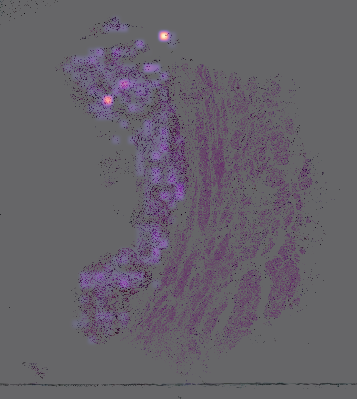

In [2]:
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
from monai.data import CacheDataset
micro_test = 'path/to/data/'
info_val =  pd.read_excel('path/to/clinical.xlsx')

Val_list = path_cleaning(micro_test,info_val)

val_data_list = prepare_data_list(Val_list)

val_dataset = CacheDataset(data=val_data_list,  cache_num=1, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

metric_logger = {'train':{'loss':[], 'pvalue':[], 'cindex':[], 'surv_acc':[]},
                    'test':{'loss':[], 'pvalue':[], 'cindex':[], 'surv_acc':[]}}

for epoch in tqdm(range(EPOCH)):

    file_path_all = []  
    loss_epoch = 0
    print('train_model_before_weight')
    print(list(model.parameters())[-1])
    slide_paths = 'path/to/svs'
    max_cindex = 0
    best_threshold = 0

    model.eval()
    file_path_all = [] 
    risk_pred_all, censor_all, survtime_all = np.array([]), np.array([]), np.array([])  
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            loss_test = 0
            graph_data = batch['features'].to(device)

            coords = np.array([coord.numpy() for coord_pair in batch['coords'] for coord in coord_pair]).reshape(-1, 2)
            pred,  attn1, attn2 = model(graph_data, return_attn=True)
            filename = 'filename'
            output_path = f'path/to/heatmap/{filename}.png'
            attn1 = attn1.squeeze(0).detach().cpu().numpy()
            
            risk_pred_all = np.concatenate((risk_pred_all, pred.detach().cpu().numpy().reshape(-1)))
            generate_heatmap(attn1, coords, slide_paths, filename, output_path)
